# High-performance image generation using Stable Diffusion in KerasCV

**Authors:** [fchollet](https://twitter.com/fchollet), [lukewood](https://twitter.com/luke_wood_ml), [divamgupta](https://github.com/divamgupta)<br>
**Date created:** 2022/09/25<br>
**Last modified:** 2022/09/25<br>
**Description:** Generate new images using KerasCV's StableDiffusion model.

## Overview

In this guide, we will show how to generate novel images based on a text prompt using
the KerasCV implementation of [stability.ai](https://stability.ai/)'s text-to-image model,
[Stable Diffusion](https://github.com/CompVis/stable-diffusion).

Stable Diffusion is a powerful, open-source text-to-image generation model.  While there
exist multiple open-source implementations that allow you to easily create images from
textual prompts, KerasCV's offers a few distinct advantages.
These include [XLA compilation](https://www.tensorflow.org/xla) and
[mixed precision](https://www.tensorflow.org/guide/mixed_precision) support,
which together achieve state-of-the-art generation speed.

In this guide, we will explore KerasCV's Stable Diffusion implementation, show how to use
these powerful performance boosts, and explore the performance benefits
that they offer.

To install the correct environment for Macbook M1 architecture with GPU support, see [README.md](./README.md). Then check if it works:

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

# It should return:
# [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

## Introduction

Unlike most tutorials, where we first explain a topic then show how to implement it,
with text-to-image generation it is easier to show instead of tell.

Check out the power of `keras_cv.models.StableDiffusion()`.

First, we construct a model:

In [ ]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

198180272/198180272 [==============================] - 2s 0us/step


Next, we give it a prompt:

25/25 [==============================] - 89s 3s/step


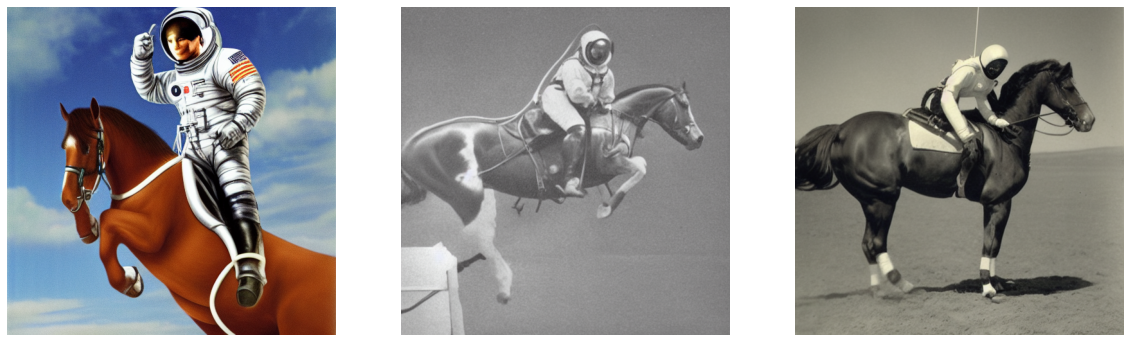

In [ ]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

Pretty incredible!

But that's not all this model can do.  Let's try a more complex prompt:

25/25 [==============================] - 64s 3s/step


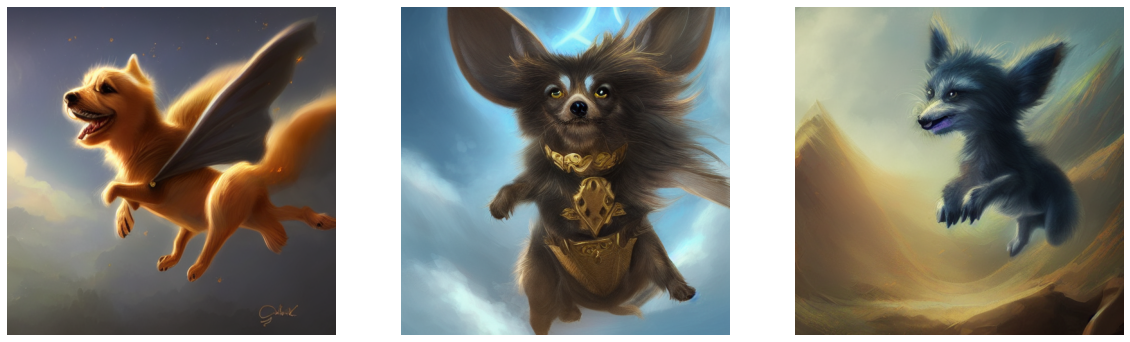

In [ ]:
images = model.text_to_image(
    "cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(images)

The possibilities are literally endless (or at least extend to the boundaries of
Stable Diffusion's latent manifold).

## Wait, how does this even work?

Unlike what you might expect at this point, StableDiffusion doesn't actually run on magic.
It's a kind of "latent diffusion model". Let's dig into what that means.

You may be familiar with the idea of _super-resolution_:
it's possible to train a deep learning model to _denoise_ an input image -- and thereby turn it into a higher-resolution
version. The deep learning model doesn't do this by magically recovering the information that's missing from the noisy, low-resolution
input -- rather, the model uses its training data distribution to hallucinate the visual details that would be most likely
given the input. To learn more about super-resolution, you can check out the following Keras.io tutorials:

- [Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/)
- [Enhanced Deep Residual Networks for single-image super-resolution](https://keras.io/examples/vision/edsr/)

![Super-resolution](https://i.imgur.com/M0XdqOo.png)

When you push this idea to the limit, you may start asking -- what if we just run such a model on pure noise?
The model would then "denoise the noise" and start hallucinating a brand new image. By repeating the process multiple
times, you can get turn a small patch of noise into an increasingly clear and high-resolution artificial picture.

This is the key idea of latent diffusion, proposed in
[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) in 2020.
To understand diffusion in depth, you can check the Keras.io tutorial
[Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/).

![Denoising diffusion](https://i.imgur.com/FSCKtZq.gif)

Now, to go from latent diffusion to a text-to-image system,
you still need to add one key feature: the ability to control the generated visual contents via prompt keywords.
This is done via "conditioning", a classic deep learning technique which consists of concatenating to the
noise patch a vector that represents a bit of text, then training the model on a dataset of {image: caption} pairs.

This gives rise to the Stable Diffusion architecture. Stable Diffusion consists of three parts:

- A text encoder, which turns your prompt into a latent vector.
- A diffusion model, which repeatedly "denoises" a 64x64 latent image patch.
- A decoder, which turns the final 64x64 latent patch into a higher-resolution 512x512 image.

First, your text prompt gets projected into a latent vector space by the text encoder,
which is simply a pretrained, frozen language model. Then that prompt vector is concatenate
to a randomly generated noise patch, which is repeatedly "denoised" by the decoder over a series
of "steps" (the more steps you run the clearer and nicer your image will be -- the default value is 50 steps).

Finally, the 64x64 latent image is sent through the decoder to properly render it in high resolution.

![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)

All-in-all, it's a pretty simple system -- the Keras implementation
fits in four files that represent less than 500 lines of code in total:

- [text_encoder.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/generative/stable_diffusion/text_encoder.py): 87 LOC
- [diffusion_model.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/generative/stable_diffusion/diffusion_model.py): 181 LOC
- [decoder.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/generative/stable_diffusion/decoder.py): 86 LOC
- [stable_diffusion.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/generative/stable_diffusion/stable_diffusion.py): 106 LOC

But this relatively simple system starts looking like magic once you train on billions of pictures and their captions.
As Feynman said about the universe: _"It's not complicated, it's just a lot of it!"_

## Perks of KerasCV

With several implementations of Stable Diffusion publicly available why shoud you use
`keras_cv.models.StableDiffusion`?

Aside from the easy-to-use API, KerasCV's Stable Diffusion model comes
with some powerful advantages, including:

- Graph mode execution
- XLA compilation through `jit_compile=True`
- Support for mixed precision computation

When these are combined, the KerasCV Stable Diffusion model runs orders of magnitude
faster than naive implementations.  This section shows how to enable all of these
features, and the resulting performance gain yielded from using them.

For the purposes of comparison, we ran benchmarks comparing the runtime of the
[HuggingFace diffusers](https://github.com/huggingface/diffusers) implementation of
Stable Diffusion against the KerasCV implementation.
Both implementations were tasked to generate 3 images with a step count of 50 for each
image.  In this benchmark, we used a Tesla T4 GPU.

[All of our benchmarks are open source on GitHub, and may be re-run on Colab to
reproduce the results.](https://github.com/LukeWood/stable-diffusion-performance-benchmarks)
The results from the benchmark are displayed in the table below:


| GPU        | Model                  | Runtime   |
|------------|------------------------|-----------|
| Tesla T4   | KerasCV (Warm Start)   | **28.97s**|
| Tesla T4   | diffusers (Warm Start) | 41.33s    |
| Tesla V100 | KerasCV (Warm Start)   | **12.45** |
| Tesla V100 | diffusers (Warm Start) | 12.72     |


30% improvement in execution time on the Tesla T4!.  While the improvement is much lower
on the V100, we generally expect the results of the benchmark to consistently favor the KerasCV
across all NVIDIA GPUs.

For the sake of completeness, both cold-start and warm-start generation times are
reported. Cold-start execution time includes the one-time cost of model creation and compilation,
and is therefore neglible in a production environment (where you would reuse the same model instance
many times). Regardless, here are the cold-start numbers:


| GPU        | Model                  | Runtime |
|------------|------------------------|---------|
| Tesla T4   | KerasCV (Cold Start)   | 83.47s  |
| Tesla T4   | diffusers (Cold Start) | 46.27s  |
| Tesla V100 | KerasCV (Cold Start)   | 76.43   |
| Tesla V100 | diffusers (Cold Start) | 13.90   |


While the runtime results from running this guide may vary, in our testing the KerasCV
implementation of Stable Diffusion is significantly faster than its PyTorch counterpart.
This may be largely attributed to XLA compilation.

**Note: The performance benefits of each optimization can vary
significantly between hardware setups.**

To get started, let's first benchmark our unoptimized model:

In [ ]:
benchmark_result = []
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Standard", end - start])
plot_images(images)

print(f"Standard model: {(end - start):.2f} seconds")
keras.backend.clear_session()  # Clear session to preserve memory.

### Mixed precision

"Mixed precision" consists of performing computation using `float16`
precision, while storing weights in the `float32` format.
This is done to take advantage of the fact that `float16` operations are backed by
significantly faster kernels than their `float32` counterparts on modern NVIDIA GPUs.

Enabling mixed precision computation in Keras
(and therefore for `keras_cv.models.StableDiffusion`) is as simple as calling:

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")

That's all.  Out of the box - it just works.

In [ ]:
model = keras_cv.models.StableDiffusion()

print("Compute dtype:", model.diffusion_model.compute_dtype)
print(
    "Variable dtype:",
    model.diffusion_model.variable_dtype,
)

As you can see, the model constructed above now uses mixed precision computation;
leveraging the speed of `float16` operations for computation, while storing variables
in `float32` precision.

In [ ]:
# Warm up model to run graph tracing before benchmarking.
model.text_to_image("warming up the model", batch_size=3)

start = time.time()
images = model.text_to_image(
    "a cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Mixed Precision", end - start])
plot_images(images)

print(f"Mixed precision model: {(end - start):.2f} seconds")
keras.backend.clear_session()

### XLA Compilation

TensorFlow comes with the
[XLA: Accelerated Linear Algebra](https://www.tensorflow.org/xla) compiler built-in.
`keras_cv.models.StableDiffusion` supports a `jit_compile` argument out of the box.
Setting this argument to `True` enables XLA compilation, resulting in a significant
speed-up.

Let's use this below:

In [ ]:
# Set back to the default for benchmarking purposes.
keras.mixed_precision.set_global_policy("float32")

model = keras_cv.models.StableDiffusion(jit_compile=True)
# Before we benchmark the model, we run inference once to make sure the TensorFlow
# graph has already been traced.
images = model.text_to_image("An avocado armchair", batch_size=3)
plot_images(images)

Let's benchmark our XLA model:

In [ ]:
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA", end - start])
plot_images(images)

print(f"With XLA: {(end - start):.2f} seconds")
keras.backend.clear_session()

On an A100 GPU, we get about a 2x speedup.  Fantastic!

## Putting it all together

So, how do you assemble the world's most performant stable diffusion inference
pipeline (as of September 2022).

With these two lines of code:

In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(jit_compile=True)

And to use it...

In [ ]:
# Let's make sure to warm up the model
images = model.text_to_image(
    "Teddy bears conducting machine learning research",
    batch_size=3,
)
plot_images(images)

Exactly how fast is it?
Let's find out!

In [ ]:
start = time.time()
images = model.text_to_image(
    "A mysterious dark stranger visits the great pyramids of egypt, "
    "high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA + Mixed Precision", end - start])
plot_images(images)

print(f"XLA + mixed precision: {(end - start):.2f} seconds")

Let's check out the results:

In [ ]:
print("{:<20} {:<20}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<20} {:<20}".format(name, runtime))

It only took our fully-optimized model four seconds to generate three novel images from
a text prompt on an A100 GPU.

## Conclusions

KerasCV offers a state-of-the-art implementation of Stable Diffusion -- and
through the use of XLA and mixed precision, it delivers the fastest Stable Diffusion pipeline available as of September 2022.

Normally, at the end of a keras.io tutorial we leave you with some future directions to continue in to learn.
This time, we leave you with one idea:

**Go run your own prompts through the model! It is an absolute blast!**

If you have your own NVIDIA GPU, or a M1 MacBookPro, you can also run the model locally on your machine.
(Note that when running on a M1 MacBookPro, you should not enable mixed precision, as it is not yet well supported
by Apple's Metal runtime.)